<a href="https://colab.research.google.com/github/SaifMahmud366/Car_Damage_Check/blob/main/ML_project_MobileNet_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!mkdir - ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [3]:
!chmod 600 /root/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d anujms/car-damage-detection

 99% 122M/123M [00:07<00:00, 23.6MB/s]
100% 123M/123M [00:07<00:00, 18.0MB/s]


In [5]:
import zipfile
zip_ref = zipfile.ZipFile('/content/car-damage-detection.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [6]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/content/data1a'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/data1a/validation/01-whole/0014.jpg
/content/data1a/validation/01-whole/0088.jpg
/content/data1a/validation/01-whole/0228.JPEG
/content/data1a/validation/01-whole/0194.jpg
/content/data1a/validation/01-whole/0226.JPEG
/content/data1a/validation/01-whole/0197.jpg
/content/data1a/validation/01-whole/0205.JPEG
/content/data1a/validation/01-whole/0196.jpg
/content/data1a/validation/01-whole/0034.jpg
/content/data1a/validation/01-whole/0160.jpg
/content/data1a/validation/01-whole/0074.jpg
/content/data1a/validation/01-whole/0064.jpg
/content/data1a/validation/01-whole/0167.jpg
/content/data1a/validation/01-whole/0063.jpg
/content/data1a/validation/01-whole/0049.jpg
/content/data1a/validation/01-whole/0009.jpg
/content/data1a/validation/01-whole/0104.jpg
/content/data1a/validation/01-whole/0080.jpg
/content/data1a/validation/01-whole/0157.jpg
/content/data1a/validation/01-whole/0159.jpg
/content/data1a/validation/01-whole/0117.jpg
/content/data1a/validation/01-whole/0003.jpg
/conten

In [7]:
from tensorflow.keras.preprocessing. image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [12]:
# Initialize constants
INIT_LR = 1e-5
EPOCHS = 50
BS = 64

# Define directories and categories
DIRECTORY = r"/content/data1a/training/"
DIRECTORY2 = r"/content/data1a/validation/"
CATEGORIES = ["00-damage", "01-whole"]

print("[INFO] loading images...")

# Initialize data and labels lists
data = []
labels = []

# Load images and preprocess for training data
for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)

        data.append(image)
        labels.append(category)

# Load images and preprocess for validation data
for category in CATEGORIES:
    path = os.path.join(DIRECTORY2, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)

        data.append(image)
        labels.append(category)

# Perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

# Convert data and labels to numpy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

# Split the data into training and testing sets
(trainX, testX, trainY, testY) = train_test_split(data, labels,
                                                  test_size=0.20, stratify=labels, random_state=42)

# Construct the training image generator for data augmentation
aug = ImageDataGenerator(rotation_range=20,
                         zoom_range=0.15,
                         width_shift_range=0.2,
                         height_shift_range=0.2,
                         shear_range=0.15,
                         horizontal_flip=True,
                         fill_mode="nearest")

[INFO] loading images...


In [13]:
baseModel =MobileNetV2 (weights="imagenet", include_top=False, input_tensor=Input (shape=(224, 224, 3)))
# construct the head of the model that will be placed on top of the
#the base model
headModel= baseModel.output
headModel= MaxPooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel= Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become # the actual model we will train)
model=Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will # not be updated during the first training process

9406464/9406464 [==============================] - 1s 0us/step


In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

In [15]:
for layer in baseModel.layers:
    layer.trainable = False
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR)
model.compile(loss="binary_crossentropy",optimizer=opt,metrics=["accuracy"])

print("[INFO]training head...")
H= model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX)//BS,
    validation_data=(testX,testY),
    validation_steps=len(testX)//BS,
    epochs=EPOCHS)

[INFO] compiling model...
[INFO]training head...
Epoch 1/50
28/28 [==============================] - 34s 907ms/step - loss: 1.1785 - accuracy: 0.6993 - val_loss: 0.5053 - val_accuracy: 0.7435
Epoch 2/50
28/28 [==============================] - 23s 813ms/step - loss: 0.4423 - accuracy: 0.8148 - val_loss: 0.4018 - val_accuracy: 0.8304
Epoch 3/50
28/28 [==============================] - 22s 791ms/step - loss: 0.3967 - accuracy: 0.8395 - val_loss: 0.3846 - val_accuracy: 0.8239
Epoch 4/50
28/28 [==============================] - 22s 769ms/step - loss: 0.3589 - accuracy: 0.8508 - val_loss: 0.2547 - val_accuracy: 0.9022
Epoch 5/50
28/28 [==============================] - 23s 822ms/step - loss: 0.3410 - accuracy: 0.8620 - val_loss: 0.2814 - val_accuracy: 0.8783
Epoch 6/50
28/28 [==============================] - 22s 795ms/step - loss: 0.3229 - accuracy: 0.8671 - val_loss: 0.3271 - val_accuracy: 0.8522
Epoch 7/50
28/28 [==============================] - 22s 779ms/step - loss: 0.3217 - accuracy:

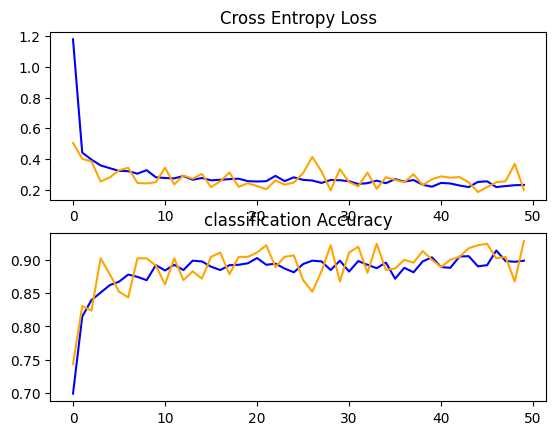

In [18]:
from  matplotlib import pyplot as plt
plt.subplot (2,1,1)
plt.title ('Cross Entropy Loss')

plt.plot(H.history['loss'],color='blue',label='train')
plt.plot(H.history['val_loss'],color ='orange',label='test')

plt.subplot(2,1,2)
plt.title('classification Accuracy')

plt.plot(H.history['accuracy'],color='blue',label='train')
plt.plot(H.history['val_accuracy'],color='orange',label='test')

plt.show()